# Graded Exercise 4

Graded index (GRIN) lenses focus light with their refractive index distribution.

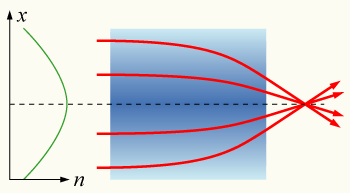

Their refractive index can be defined as: $n(r)=n_{\max }\left(1-\frac{\alpha r^2}{2}\right)$

$n_{\max }$ stands for the maximum refractive index, which is found on the center of the lens, $\alpha$ controls the curvature of the refractive index profile.

Accordingly, the focal length of the lens is $f=\frac{1}{n_{\max } \alpha d}$.

Using the provided initial code,

a) Run BPM simulation for $n_{\max } = 1.05$ and $\alpha = 10^7$. Estimate focal length $f_L$ and FWHM at the focal plane. While varying the sampling z-step of the simulation (dz), track FWHM and $f_L$ values. Suggest an optimal dz for accurate prediction of lens properties while minimizing computational cost.

b) Follow the same steps in (a) for $n_{\max } = 1.05$ and $\alpha = 3 \times 10^7$. Compare the optimal dz with the one in (a). Explain physically and comment on the obtained outcome.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
array_size = 200e-6  
num_pixels = 512  # Resolution

dx = array_size / num_pixels  # Pixel size

wvl = 633e-9
dz = 3e-6


# Create spatial coordinate grid
x = np.linspace(-array_size / 2, array_size / 2, num_pixels)
y = np.linspace(-array_size / 2, array_size / 2, num_pixels)
X, Y = np.meshgrid(x, y)

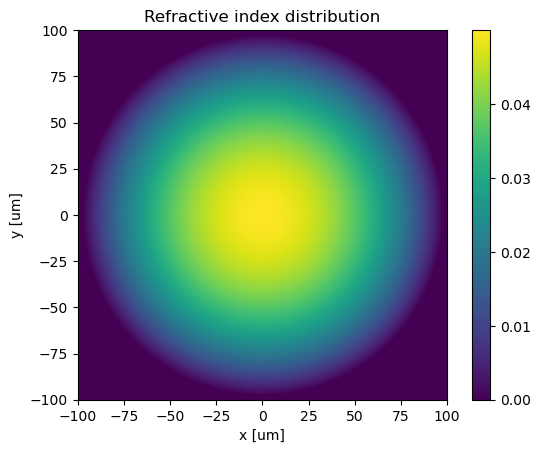

In [3]:
n_max =1.05
alpha =1e7
rho = np.sqrt(X**2+Y**2)
grin_dist = np.maximum(n_max*(1-alpha*rho**2/2)-1,0)
plt.imshow(grin_dist,extent=[-array_size*1e6/2,array_size*1e6/2,-array_size*1e6/2,array_size*1e6/2]); plt.colorbar(); 
plt.title('Refractive index distribution')
plt.xlabel('x [um]')
plt.ylabel('y [um]')  
plt.show()

In [4]:
def angular_spectrum_propagation_range_grin(U0, wvl, dx, dz, num_steps, num_steps_grin, grin_dist, absorptive_boundary= False):
    """
    Propagates an optical field using the Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 2D numpy array (input wavefield)
        wvl     : float (wavelength of light in meters)
        d_range : list or numpy array (range of propagation distances in meters)
        dx      : float (sampling interval in meters)

    Returns:
        U_list  : list of 2D numpy arrays (propagated wavefields for each distance in d_range)
    """
    
    # Define refractive index
    
    # Get array size
    ny, nx = U0.shape
    k = 2 * np.pi / wvl  # Wave number

    # Create spatial frequency coordinates
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy)
    
    # Initialize list to store results
    U_list = []
    
    # Apply super Gaussian absorptive boundary

    if absorptive_boundary:
        sigma = nx/3.5  # Standard deviation for Gaussian
        X, Y = np.meshgrid(np.linspace(-nx/2, nx/2, nx), np.linspace(-ny/2, ny/2, ny))
        window = np.exp(-((X**2 + Y**2) / (2 * sigma**2))**4)
    else:
        window = np.ones_like(U0)
        
    H = np.exp(1j * k * dz * np.sqrt(0j+ 1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    for _ in range(num_steps_grin):
        
        U_spectrum = np.fft.fft2(U0 * np.exp(1j * k * dz * grin_dist))
        # Inverse FFT to obtain propagated field
        U0 = np.fft.ifft2(U_spectrum)
        U0 *= window
        U_list.append(U0)

    for _ in range(num_steps-num_steps_grin):
        
        # Apply transfer function
        U_spectrum = np.fft.fft2(U0) * H
        
        # Inverse FFT to obtain propagated field
        U0 = np.fft.ifft2(U_spectrum)
        U0 *= window
        U_list.append(U0)        
    return U_list


FWHM at dz=5.00 um: 2.73 um
FWHM at dz=7.50 um: 2.73 um
FWHM at dz=11.25 um: 2.73 um
FWHM at dz=16.88 um: 2.73 um
FWHM at dz=25.31 um: 2.73 um


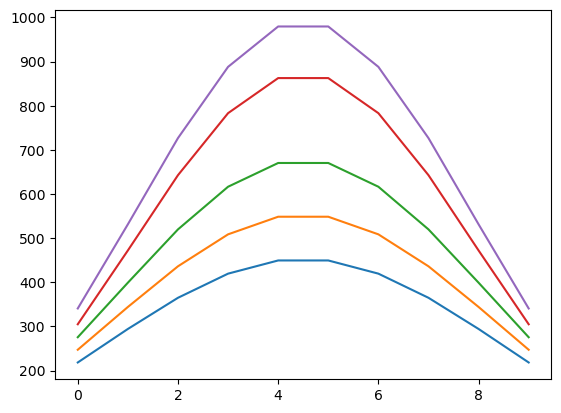

In [29]:
prop_distance = 0.8e-3
prop_steps = np.round(prop_distance / dz).astype(int)

prop_distance_grin = 0.18e-3
prop_steps_grin = np.round(prop_distance_grin / dz).astype(int)

U0 = np.ones_like(X)
max_locs = []
fwhms = []
dz_vals = 5e-6*1.5**np.arange(0,5)

for dz in dz_vals:
    prop_steps = np.round(prop_distance / dz).astype(int)
    prop_steps_grin = np.round(prop_distance_grin / dz).astype(int)
    grating_zs = angular_spectrum_propagation_range_grin(U0, wvl, dx, dz, prop_steps, prop_steps_grin,grin_dist, True)
    array_3d = np.stack(grating_zs)
    max_loc = np.unravel_index(np.argmax(np.abs(array_3d)**2), array_3d.shape)

    max_locs.append(max_loc)
        
    intensity_profile = np.abs(array_3d[max_loc[0],int(num_pixels/2),int(num_pixels/2) -5:int(num_pixels/2) +5])**2
    plt.plot(intensity_profile)
    # Estimate the full width half maximum (FWHM)
    half_max = np.max(intensity_profile) / 2
    indices = np.where(intensity_profile >= half_max)[0]
    fwhm = (indices[-1] - indices[0]) * dx
    fwhms.append(fwhm)
    print(f"FWHM at dz={dz*1e6:.2f} um: {fwhm*1e6:.2f} um")



Text(0.5, 0, 'Step size [um]')

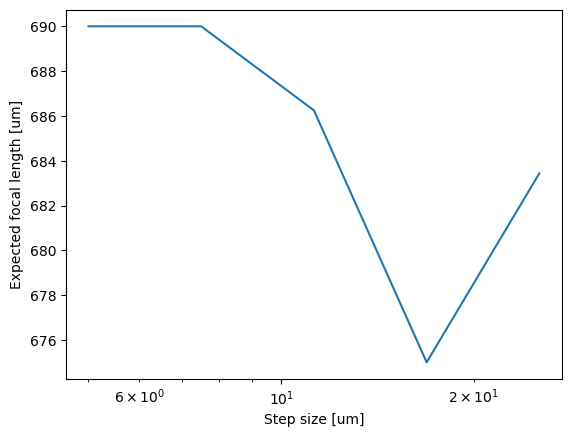

In [19]:
max_locs = np.array(max_locs)
plt.semilogx(dz_vals*1e6, max_locs[:,0]*dz_vals*1e6,label='x')
plt.ylabel('Expected focal length [um]')
plt.xlabel('Step size [um]')

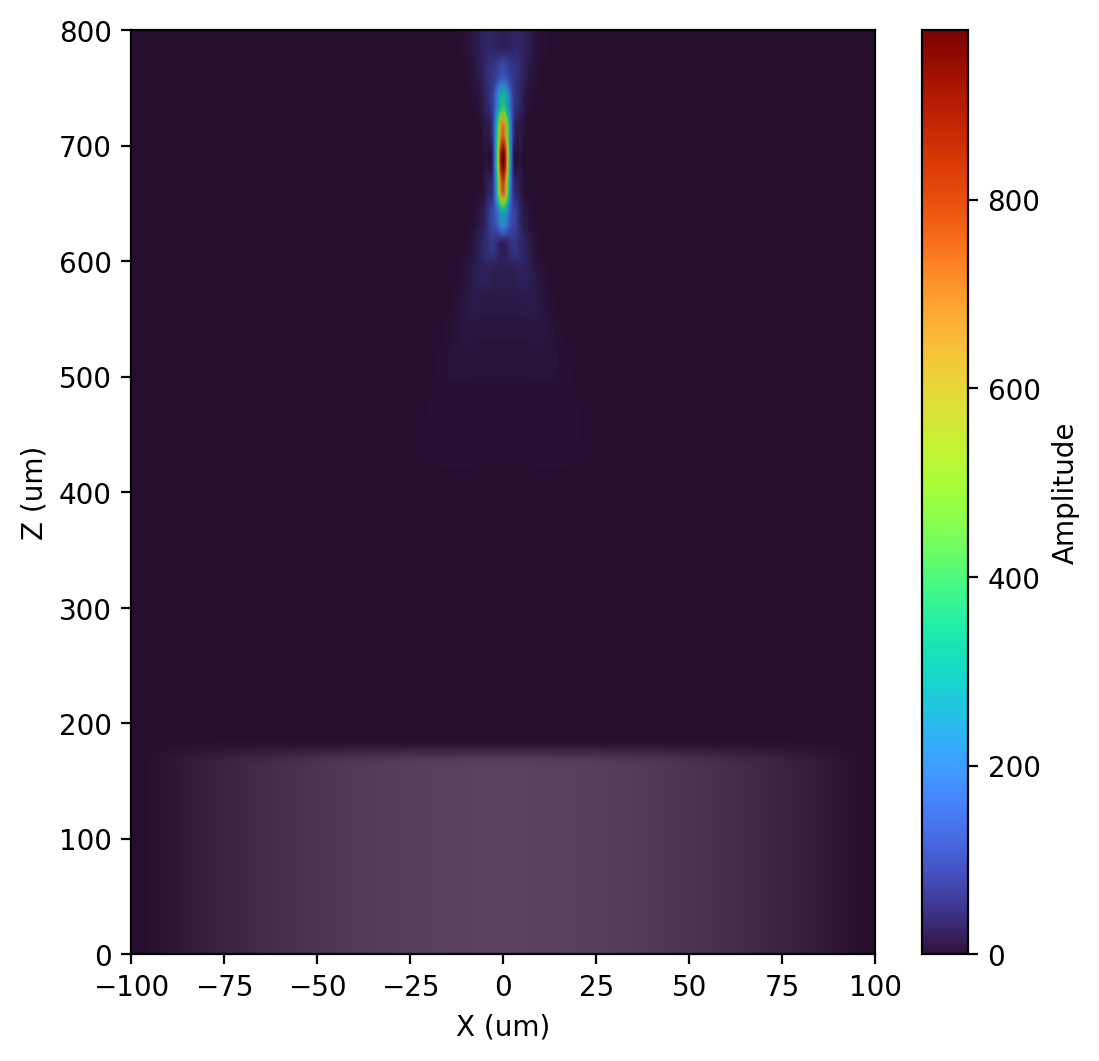

In [30]:
# Display the grating
plt.figure(figsize=(6, 6),dpi = 200)
plt.imshow(np.abs(array_3d[:, 256, :])**2, cmap="turbo",aspect = 'auto',extent=[-array_size/2*1e6, array_size/2*1e6, prop_distance*1e6,0],alpha= 1.0)
# plt.clim(0, 0.1)

plt.colorbar(label="Amplitude")

grin_dist_1d = grin_dist[256, :]
refractive_distribution = np.ones_like(np.abs(array_3d[:, 256, :]).squeeze())
refractive_distribution[0:prop_steps_grin] = 1+grin_dist_1d[None,:]

plt.imshow(np.flip(refractive_distribution,axis = 0), cmap="gray",aspect = 'auto',extent=[-array_size/2*1e6, array_size/2*1e6, 0, prop_distance*1e6],alpha= 0.2)
plt.xlabel("X (um)")
plt.ylabel("Z (um)")
plt.show()

In [8]:
focal_distance = 1/(n_max*alpha*prop_distance_grin)*1e6+prop_distance_grin*1e6
print(focal_distance)


709.100529100529


a) While the simulation stays accurate in terms of FWHM, we see that for steps larger than 10 um, the variability of predictions become large. So 10 um could be an ideal sampling step.

# Part B

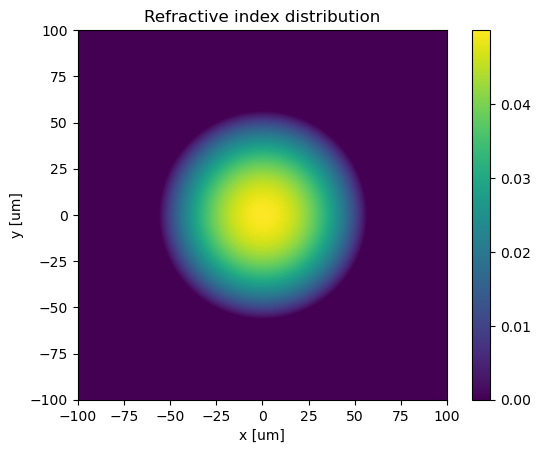

In [31]:
n_max =1.05
alpha =3e7
rho = np.sqrt(X**2+Y**2)
grin_dist = np.maximum(n_max*(1-alpha*rho**2/2)-1,0)
plt.imshow(grin_dist,extent=[-array_size*1e6/2,array_size*1e6/2,-array_size*1e6/2,array_size*1e6/2]); plt.colorbar(); 
plt.title('Refractive index distribution')
plt.xlabel('x [um]')
plt.ylabel('y [um]')  
plt.show()

FWHM at dz=5.00 um: 1.17 um
FWHM at dz=7.50 um: 1.17 um
FWHM at dz=11.25 um: 0.39 um
FWHM at dz=16.88 um: 0.39 um
FWHM at dz=25.31 um: 1.17 um


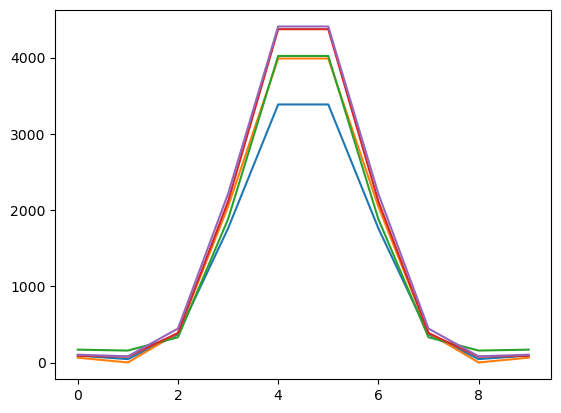

In [32]:
prop_distance = 0.8e-3
prop_steps = np.round(prop_distance / dz).astype(int)

prop_distance_grin = 0.18e-3
prop_steps_grin = np.round(prop_distance_grin / dz).astype(int)

U0 = np.ones_like(X)
max_locs = []
fwhms = []
dz_vals = 5e-6*1.5**np.arange(0,5)

for dz in dz_vals:
    prop_steps = np.round(prop_distance / dz).astype(int)
    prop_steps_grin = np.round(prop_distance_grin / dz).astype(int)
    grating_zs = angular_spectrum_propagation_range_grin(U0, wvl, dx, dz, prop_steps, prop_steps_grin,grin_dist, True)
    array_3d = np.stack(grating_zs)
    max_loc = np.unravel_index(np.argmax(np.abs(array_3d)**2), array_3d.shape)

    max_locs.append(max_loc)
        
    intensity_profile = np.abs(array_3d[max_loc[0],int(num_pixels/2),int(num_pixels/2) -5:int(num_pixels/2) +5])**2
    plt.plot(intensity_profile)
    # Estimate the full width half maximum (FWHM)
    half_max = np.max(intensity_profile) / 2
    indices = np.where(intensity_profile >= half_max)[0]
    fwhm = (indices[-1] - indices[0]) * dx
    fwhms.append(fwhm)
    print(f"FWHM at dz={dz*1e6:.2f} um: {fwhm*1e6:.2f} um")



Text(0.5, 0, 'Step size [um]')

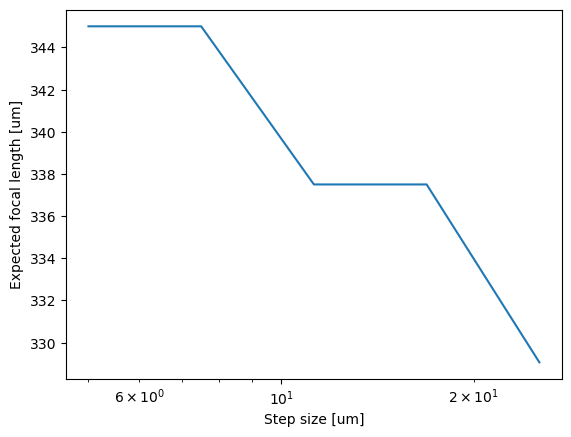

In [33]:
max_locs = np.array(max_locs)
plt.semilogx(dz_vals*1e6, max_locs[:,0]*dz_vals*1e6,label='x')
plt.ylabel('Expected focal length [um]')
plt.xlabel('Step size [um]')

b) In this case, where the focal length is shorter, we observe higher variability of expected values for dz longer than 7.5 um. Also, the tighter focus requires better transverse sampling.

The requirement of finer sampling with shorter focal length can be attributed to the larger NA of the lens, meaning that light propagates at larger angles and has to be sampled more frequently before it wraps around. 